In [36]:
import torch

device = torch.device("mps")

In [37]:
import duckdb

train_path = 'train.parquet'
con = duckdb.connect()

data = con.query(f"""
    (SELECT *
    FROM parquet_scan('{train_path}')
    WHERE binds = 0
    ORDER BY random() LIMIT 100000)
    UNION ALL
    (SELECT *
    FROM parquet_scan('{train_path}')
    WHERE binds = 1
    ORDER BY random() LIMIT 100000) 
""").df()

data.head()



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,36989954,COc1ccc(NC(=O)OCC2c3ccccc3-c3ccccc32)c(C(=O)O)c1,Nc1nc(C2CC2)cs1,COC(CN)CC(N)=O.Cl,COc1ccc(Nc2nc(NCC(CC(N)=O)OC)nc(Nc3nc(C4CC4)cs...,sEH,0
1,121881857,O=C(N[C@H](Cc1ccc(Cl)c(Cl)c1)C(=O)O)OCC1c2cccc...,Nc1ccc2c(c1)CCCC2=O,NCc1cccc(N2CCOCC2)c1,O=C1CCCc2cc(Nc3nc(NCc4cccc(N5CCOCC5)c4)nc(N[C@...,sEH,0
2,56631755,Cc1ccc(C(CC(=O)O)NC(=O)OCC2c3ccccc3-c3ccccc32)cc1,Nc1nccc2cccnc12,Nc1cnc(Cl)cc1Cl,Cc1ccc(C(CC(=O)N[Dy])Nc2nc(Nc3cnc(Cl)cc3Cl)nc(...,sEH,0
3,64351512,N#Cc1ccc(C[C@@H](NC(=O)OCC2c3ccccc3-c3ccccc32)...,CC1(C)NC(=O)N(CCCN)C1=O.Cl,CC1CCc2nc(CN)sc2C1,CC1CCc2nc(CNc3nc(NCCCN4C(=O)NC(C)(C)C4=O)nc(N[...,BRD4,0
4,133162387,O=C(Nc1c(Br)cc(C(=O)O)cc1Br)OCC1c2ccccc2-c2ccc...,COc1cc(N)ccn1,NCc1nc2c(s1)CCCCC2,COc1cc(Nc2nc(NCc3nc4c(s3)CCCCC4)nc(Nc3c(Br)cc(...,HSA,0


In [38]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder(sparse=False)
encoded_protein = encoder.fit_transform(data[['protein_name']])
encoded_protein_df = pd.DataFrame(encoded_protein, columns=encoder.get_feature_names_out(['protein_name']))
encoded_protein_df

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,protein_name_BRD4,protein_name_HSA,protein_name_sEH
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,1.0,0.0
...,...,...,...
199995,0.0,1.0,0.0
199996,1.0,0.0,0.0
199997,0.0,1.0,0.0
199998,0.0,0.0,1.0


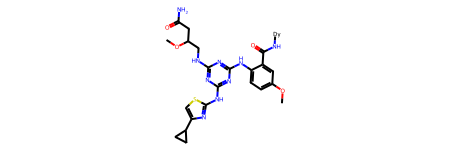

In [39]:
from rdkit import Chem

smiles = data['molecule_smiles'][0]
mol = Chem.MolFromSmiles(smiles)
mol

# 화합물을 텐서로 표현해보자 (by. GNN)

## Create Vocab

In [40]:
ATOM_VOCAB = []

def create_vocab(chunk):
    global ATOM_VOCAB
    for smiles in chunk['molecule_smiles']:
        mol = Chem.MolFromSmiles(smiles)
        atom_set = set(mol.GetAtoms())

        for atom in list(atom_set):
            atom = atom.GetSymbol()
            
            if atom in ATOM_VOCAB:
                continue
            
            ATOM_VOCAB.append(atom)
    



In [41]:
from concurrent.futures import ThreadPoolExecutor

n_workers = 10
chunk_size = 200
chunks = [data.iloc[i:i+chunk_size] for i in range(0, len(data), chunk_size)]


with ThreadPoolExecutor(max_workers = n_workers) as executor:
    fs = executor.map(create_vocab, chunks)



In [42]:
ATOM_VOCAB

['C', 'N', 'S', 'O', 'Dy', 'Cl', 'Br', 'F', 'I', 'Si', 'B']

In [51]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, mean_squared_error, r2_score
import numpy as np

def evaluate_classification(
		y_list,
		pred_list,
	):
	y_list = torch.cat(y_list, dim=0).detach().cpu().numpy()
	pred_list = torch.cat(pred_list, dim=0).detach().cpu().numpy()

	auroc = roc_auc_score(y_list, pred_list)

	'''
	To calculate metric in the below,
	scores should be presented in integer type
	'''
	
	y_list = y_list.astype(int)
	pred_list = np.around(pred_list).astype(int)

	accuracy = accuracy_score(y_list, pred_list)
	precision = precision_score(y_list, pred_list)
	recall = recall_score(y_list, pred_list)
	f1 = 2.0 * precision * recall / (precision + recall)
	return accuracy, auroc, precision, recall, f1

# Datasets

In [52]:
import dgl

def one_of_k_encoding(x, vocab):
    if x not in vocab:
        x = vocab[-1]

    return list(map(lambda s : float(x==s), vocab))

def get_atom_feature(atom):
    atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB) # 만약 atom == c 이면 [1, 0, 0, 0, ...] 반환됨
    atom_feature += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
    atom_feature += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    atom_feature += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
    atom_feature += [atom.GetIsAromatic()]

    return atom_feature

def get_bond_feature(bond):
    bt = bond.GetBondType()
    bond_feature = [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]

    return bond_feature

def get_molecular_graph(smi):
    mol = Chem.MolFromSmiles(smi)
    graph = dgl.DGLGraph()

    # atom 에대한 feature를 tensor로 만들어서 graph.ndata['h']에 저장
    atom_list = mol.GetAtoms()
    num_atoms = len(atom_list)
    graph.add_nodes(num_atoms) # atom 개수 만큼 노드 추가

    atom_feature_list = [get_atom_feature(atom) for atom in atom_list] # [[1, 0, ...], ... (atom 개수만큼)]
    atom_feature_tensor = torch.tensor(atom_feature_list, dtype=torch.float64) # 위 리스트를 tensor로 바꾸네
    graph.ndata['h'] = atom_feature_tensor 

    # bond에 대한 feature를 tensor로 만들어서 graph.edata['e_ij']에 저장
    bond_list = mol.GetBonds()
    bond_feature_list = []

    for bond in bond_list:
        bond_feature = get_bond_feature(bond) # [1, 0, 0 ,0 ,0 ] 과 같은 값 반환 : bond type에 따라 1값이 하나 있는 onehot

        src = bond.GetBeginAtom().GetIdx()
        dest = bond.GetEndAtom().GetIdx()
        
        # i --> j
        graph.add_edges(src, dest)
        bond_feature_list.append(bond_feature)

        # j --> i
        graph.add_edges(dest, src)
        bond_feature_list.append(bond_feature)

    bond_feature_tensor = torch.tensor(bond_feature_list, dtype=torch.float64) 
    graph.edata['e_ij'] = bond_feature_tensor
    return graph

In [53]:
from sklearn.preprocessing import OneHotEncoder

class MyDataset(torch.utils.data.Dataset):
	def __init__(
			self, 
			splitted_set
		):
		self.smi_list = list(splitted_set['molecule_smiles'])
		self.protein_list = list(splitted_set['protein_name'])
		self.label_list = list(splitted_set['binds'])
	
	def __len__(self):
		return len(self.smi_list)
	
	def __getitem__(
			self, 
			idx
		):

		return self.smi_list[idx], self.label_list[idx]

def my_collate_fn(batch):
	graph_list = []
	label_list = []
	for item in batch:
		smi = item[0]
		label = item[1]
		graph = get_molecular_graph(smi)
		graph_list.append(graph)
		label_list.append(label)
	graph_list = dgl.batch(graph_list)
	label_list = torch.tensor(label_list, dtype=torch.float64)
	return graph_list, label_list

In [54]:
from torch.utils.data import DataLoader

test_df = data.sample(frac=0.2, random_state=42)
train_df = data.drop(test_df.index)

train_ds = MyDataset(splitted_set=train_df)
test_ds = MyDataset(splitted_set=test_df)

train_loader = DataLoader(
    dataset = train_ds,
    batch_size = 20000,
    shuffle = True,
    num_workers = 10,
    collate_fn = my_collate_fn
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = 1000,
    shuffle = False,
    num_workers= 10,
    collate_fn = my_collate_fn
)


## GAT Model 생성

In [55]:
import torch.nn as nn
import torch.nn.functional as F

import math

import dgl.function as fn
from dgl.nn.functional import edge_softmax

class MLP(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dim,
            output_dim,
            bias=True,
            act=F.relu,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.act = act

        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=bias)

    def forward(self, h):
        h = self.linear1(h)
        h = self.act(h)
        h = self.linear2(h)
        return h
    
class GraphAttention(nn.Module):
    def __init__(
            self,
            hidden_dim,
            num_heads = 4,
            bias_mlp = True,
            dropout_prob = 0.2,
            act = F.relu,
    ):
        super().__init__()

        self.mlp = MLP(
            input_dim = hidden_dim,
            hidden_dim = 2 * hidden_dim,
            output_dim = hidden_dim,
            bias = bias_mlp,
            act = act
        )

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.splitted_dim = hidden_dim // num_heads

        self.prob = dropout_prob

        self.w1 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.w2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.w3 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.w4 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.w5 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.w6 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        
        self.act = F.elu
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(
            self,
            graph,
            training = False,
    ):
        h0 = graph.ndata['h']
        e_ij = graph.edata['e_ij']

        graph.ndata['u'] = self.w1(h0).view(-1, self.num_heads, self.splitted_dim)
        graph.ndata['v'] = self.w2(h0).view(-1, self.num_heads, self.splitted_dim)
        graph.edata['x_ij'] = self.w3(e_ij).view(-1, self.num_heads, self.splitted_dim)

        graph.apply_edges(fn.v_add_e('v', 'x_ij', 'm'))
        graph.apply_edges(fn.u_mul_e('u', 'm', 'attn'))
        graph.edata['attn'] = edge_softmax(graph, graph.edata['attn'] / math.sqrt(self.splitted_dim))

        graph.ndata['k'] = self.w4(h0).view(-1, self.num_heads, self.splitted_dim)
        graph.edata['x_ij'] = self.w5(e_ij).view(-1, self.num_heads, self.splitted_dim)
        graph.apply_edges(fn.v_add_e('k', 'x_ij', 'm'))

        graph.edata['m'] = graph.edata['attn'] * graph.edata['m']
        graph.update_all(fn.copy_edge('m', 'm'), fn.sum('m', 'h'))

        h = self.w6(h0) + graph.ndata['h'].view(-1, self.hidden_dim)
        h = self.norm(h)

        h = h + self.mlp(h)
        h = self.norm(h)

        h = F.dropout(h, p = self.prob, training = training)

        graph.ndata['h'] = h
        return graph

In [56]:
class MyModel(nn.Module):
    def __init__(
            self,
            num_layers = 4,
            initial_node_dim = 58,
            initial_edge_dim = 6,
            hidden_dim = 64,
            num_heads = 4,
            dropout_prob = 0.2):
        super().__init__()
        self.num_layers = num_layers
        self.embedding_node = nn.Linear(initial_node_dim, hidden_dim, bias = False)
        self.embedding_edge = nn.Linear(initial_edge_dim, hidden_dim, bias = False)
        self.layers = torch.nn.ModuleList()

        for _ in range(self.num_layers):
            layer = GraphAttention(
                hidden_dim = hidden_dim,
                num_heads = num_heads,
                dropout_prob = dropout_prob,
                act = F.relu,
                bias_mlp = True
            )
            self.layers.append(layer)

        self.mlp_out = MLP(input_dim= hidden_dim+3, hidden_dim= hidden_dim, output_dim = 1)
        self.sigmoid = F.sigmoid

    def forward(self, graph, protein, training = False):
        h = self.embedding_node(graph.ndata['h'].float())
        e_ij = self.embedding_node(graph.edata['e_ij'].float())

        graph.ndata['h'] = h
        graph.edata['e_ij'] = e_ij

        for i in range(self.num_layer):
            graph = self.layers[i](graph = graph, training = training)

        out = dgl.readout_nodes(graph, 'h', op = 'sum')
        '''
        out = self.mlp_out(out+protein)
        out = self.sigmoid(out)
        '''
        return out


In [57]:
num_epochs = 100

model = MyModel()
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.1,
    weight_decay = 0
)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=40,
    gamma=0.1,
)

bce_loss = nn.BCEWithLogitsLoss()

In [58]:
for epoch in range(num_epochs):
    model.train()
    num_batchs = len(train_loader)
    train_loss = 0
    y_list = []
    pred_list = []

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()

        graph, y = batch[0], batch[1]
        graph = graph.to(device)
        y = y.to(device)
        y = y.float()

        pred = model(graph).squeeze()
        y_list.append(y)
        pred_list.append(pred)

        loss = bce_loss(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach().cpu().numpy()
    
    scheduler.stpe()
    train_loss /= num_batchs
    train_metrics = evaluate_classification(
        y_list = y_list,
        pred_list = pred_list
    )

    model.eval()
    with torch.no_grad():
        test_loss = 0
        num_batches = len(test_loader)
        y_list = []
        pred_list = []
        for i, batch in enumerate(test_loader):
            graph, y = batch[0], batch[1]
            graph = graph.to(device)
            y = y.to(device)
            y = y.float()

            pred = model(graph).squeeze()
            y_list.append(y)
            pred_list.append(pred)

            loss = bce_loss(pred, y)
            test_loss += loss.detach().cpu().numpy()

        test_loss /= num_batches
        test_metrics = evaluate_classification(
            y_list = y_list,
            pred_list = pred_list
        )
    print ("End of ", epoch+1, "-th epoch", \
			   "Accuracy:", round(train_metrics[0], 3), "\t", round(test_metrics[0], 3), \
			   "AUROC:", round(train_metrics[1], 3), "\t", round(test_metrics[1], 3), \
			   "Precision:", round(train_metrics[2], 3), "\t", round(test_metrics[2], 3), \
			   "Recall:", round(train_metrics[3], 3), "\t", round(test_metrics[3], 3), \
			   "F1-score:", round(train_metrics[4], 3), "\t", round(test_metrics[4], 3), \
			   "ECE:", round(train_metrics[5], 3), "\t", round(test_metrics[5], 3))
        

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MyDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 